# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

### Import the necessary libraries

In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

### Change directory

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/images')

In [0]:
#!unrar x images_racoon.rar

In [0]:
!ls -l

total 13059
drwx------ 2 root root   4096 Apr 21 06:22 images
-rw------- 1 root root 118176 Apr 20 17:52 raccoon-100.jpg
-rw------- 1 root root 124554 Apr 20 17:52 raccoon-101.jpg
-rw------- 1 root root  17123 Apr 20 17:52 raccoon-102.jpg
-rw------- 1 root root 173619 Apr 20 17:52 raccoon-103.jpg
-rw------- 1 root root  41618 Apr 20 17:52 raccoon-104.jpg
-rw------- 1 root root  99844 Apr 20 17:52 raccoon-105.jpg
-rw------- 1 root root  13337 Apr 20 17:52 raccoon-106.jpg
-rw------- 1 root root  95486 Apr 20 17:52 raccoon-107.jpg
-rw------- 1 root root  92585 Apr 20 17:52 raccoon-108.jpg
-rw------- 1 root root  18709 Apr 20 17:52 raccoon-109.jpg
-rw------- 1 root root  70541 Apr 20 17:52 raccoon-10.jpg
-rw------- 1 root root  13357 Apr 20 17:52 raccoon-110.jpg
-rw------- 1 root root 137606 Apr 20 17:52 raccoon-111.jpg
-rw------- 1 root root 162431 Apr 20 17:52 raccoon-112.jpg
-rw------- 1 root root 249753 Apr 20 17:52 raccoon-113.jpg
-rw------- 1 root root  88708 Apr 20 17:52 raccoon-114

### Load the training data from train.csv file

In [0]:
train_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')

In [0]:
train_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [0]:
num_classes=train_df['class'].unique()

In [0]:
num_classes

array(['raccoon'], dtype=object)

### Print the shape of the train dataset

In [0]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
img_size = 128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))
        #Classification Labels 
        batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'filename'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array


            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = tf.keras.applications.mobilenet.preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_bboxes]

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.applications.MobileNet(include_top=False, #Do not include FC layer at the end
                                          input_shape=(img_size,img_size, 3),
                                          weights='imagenet')

In [0]:
for layer in model.layers:
    layer.trainable = False

In [0]:
#get Output layer of Pre-trained model
x = model.output

#Flatten the output to feed to Dense layer
x = tf.keras.layers.Flatten()(x)

#Add Dropout
x = tf.keras.layers.Dropout(0.5)(x)

#Add one Dense layer
x = tf.keras.layers.Dense(200, activation='relu')(x)

#Batch Norm
x = tf.keras.layers.BatchNormalization()(x)

In [0]:
bbox_output = tf.keras.layers.Dense(4 , activation='sigmoid', name='reg_op')(x)

### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
def calculate_iou(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

In [0]:
#Non Sequential model as it has two different outputs
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=[bbox_output]) 

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
final_model.compile(optimizer='adam', 
                    loss={'reg_op':'mse'},
                    loss_weights={'reg_op':1},
                    metrics=[IoU])

In [0]:
#Create train and test generator
batchsize = 32
train_generator = batch_generator(train_df, batch_size=batchsize) #batchsize can be changed

In [0]:
final_model.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train_df.shape[0]//batchsize,verbose = 1)

Epoch 1/30
5/5 [==============================] - 2s 317ms/step - loss: 0.1767 - IoU: 0.1542
Epoch 2/30
5/5 [==============================] - 0s 52ms/step - loss: 0.1602 - IoU: 0.2076
Epoch 3/30
5/5 [==============================] - 1s 161ms/step - loss: 0.1495 - IoU: 0.2746
Epoch 4/30
5/5 [==============================] - 1s 165ms/step - loss: 0.1233 - IoU: 0.2741
Epoch 5/30
5/5 [==============================] - 1s 167ms/step - loss: 0.1091 - IoU: 0.3238
Epoch 6/30
5/5 [==============================] - 1s 163ms/step - loss: 0.0956 - IoU: 0.4120
Epoch 7/30
5/5 [==============================] - 1s 168ms/step - loss: 0.0897 - IoU: 0.3808
Epoch 8/30
5/5 [==============================] - 1s 171ms/step - loss: 0.0780 - IoU: 0.4602
Epoch 9/30
5/5 [==============================] - 1s 165ms/step - loss: 0.0675 - IoU: 0.4934
Epoch 10/30
5/5 [==============================] - 1s 161ms/step - loss: 0.0714 - IoU: 0.4703
Epoch 11/30
5/5 [==============================] - 1s 169ms/step - los

### Pick a test image from the given data

In [0]:
#Load image
    img = tf.keras.preprocessing.image.load_img(train_df.loc[10, 'filename'])
    w, h = img.size

In [0]:
xmin, ymin, xmax, ymax = train_df.loc[10, ['xmin', 'ymin', 'xmax', 'ymax']]

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((img_size, img_size)) 
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)
    #3. Normalize image data
    input_array = tf.keras.applications.mobilenet.preprocess_input(input_array)

### Predict the coordinates of the bounding box for the given test image

In [0]:
 pred = final_model.predict(input_array)

In [0]:
label_pred, bbox_pred = pred[0][0], pred[0][1]

In [0]:
pred.shape

(1, 4)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

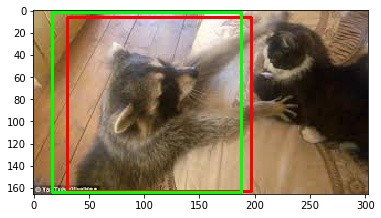

In [0]:
#Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(train_df.loc[10, 'filename'])
    #Draw actual bounding box
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 2)
    #Draw predicted bounding box
    img = cv2.rectangle(img, (int(pred[0][0]*w), int(pred[0][1]*h)), 
                        (int((pred[0][0]+pred[0][2])*w), int((pred[0][1]+pred[0][3])*h)), (0,255,0), 2)

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

In [0]:
# Import the necessary libraries

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

In [0]:
#already Mounted

#### Change your present working directory

In [0]:
#already set

### Load your data file

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/daily-minimum-temperatures-in-me.csv',index_col='Date')
print(df.head())

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


#### Plot data

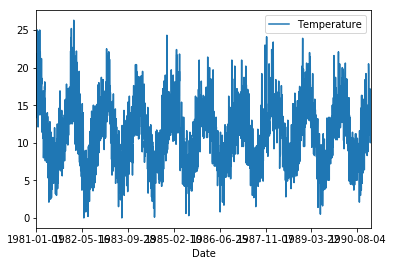

In [0]:
df.plot()

#### Descibe your dataframe

#### Check for null values

In [0]:
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
#no null Values

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f617a63b128>]],
      dtype=object)

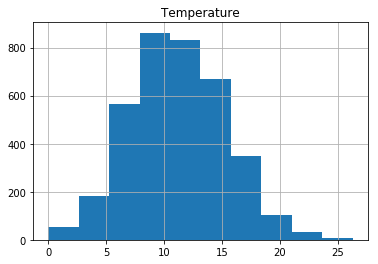

In [185]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [187]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [190]:

print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [191]:
print(scaled[:10])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159696]
 [0.82889734]
 [0.76045627]]


### Split data into Training and Testing

In [192]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [194]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190113
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749048
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642585
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490494
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673003
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254752
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [199]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/10
 - 11s - loss: 0.0233
Epoch 2/10
 - 11s - loss: 0.0155
Epoch 3/10
 - 11s - loss: 0.0128
Epoch 4/10
 - 11s - loss: 0.0119
Epoch 5/10
 - 11s - loss: 0.0112
Epoch 6/10
 - 10s - loss: 0.0107
Epoch 7/10
 - 10s - loss: 0.0106
Epoch 8/10
 - 11s - loss: 0.0104
Epoch 9/10
 - 11s - loss: 0.0103
Epoch 10/10
 - 11s - loss: 0.0101


### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

In [201]:
print(trainPredict)
print(testPredict)

[[0.653852  ]
 [0.59795356]
 [0.6269237 ]
 ...
 [0.55371475]
 [0.49952456]
 [0.509267  ]]
[[0.04773641]
 [0.31189474]
 [0.41510978]
 ...
 [0.49710777]
 [0.48941812]
 [0.48749956]]


In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [205]:
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.59 RMSE
Test Score: 2.47 RMSE


## Plot the results

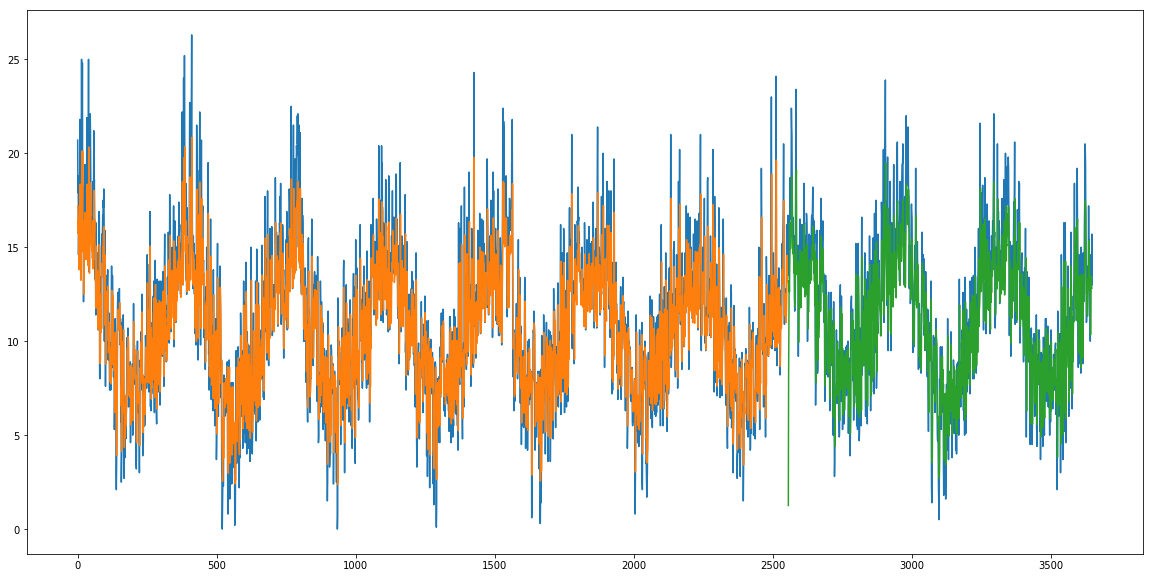

In [206]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()